In [1]:
from datasets import load_dataset
# dset = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
dset = load_dataset("kresnik/librispeech_asr_test", "clean")['test'].shuffle().select(list(range(200)))
dset = dset.remove_columns(['speaker_id', 'chapter_id','id'])
print(dset)

import numpy as np
from datasets import load_metric
wer_metric = load_metric("wer")

Downloading:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

Dataset librispeech_asr downloaded and prepared to /home-nfs/goutham/.cache/huggingface/datasets/kresnik___librispeech_asr/clean/2.1.0/16bc288fa237b20821c5b51c8c09426b2689d8c5a889287589cb12aba6705e74. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['file', 'audio', 'text'],
    num_rows: 200
})


Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

In [2]:
import torch
from transformers import Wav2Vec2Processor
from custom_wav2vec2 import Wav2Vec2ForCTC

w2v_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").cuda()

def layer_noisy_decoding(batch, noise_layer, noise):
    speech = batch["audio"]["array"]
    input_values = w2v_processor(speech, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
    input_values = input_values.to("cuda")
    if noise_layer == -1: # No noise
        logits = w2v_model(input_values).logits
    else:
        logits = w2v_model(input_values, noise_layer = noise_layer, noise = noise).logits
    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = w2v_processor.batch_decode(pred_ids)[0]
    return batch

noises = np.arange(0, .65, .1)
layers = list(range(-1, 13, 1))
vals = []
for noise in noises:
    vals.append([])
    for layer in layers:
        new_dset = dset.map(layer_noisy_decoding, 
                            fn_kwargs = {"noise": noise, "noise_layer": layer}, 
                            batch_size = 1,
                            load_from_cache_file=False)
        wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])
        vals[-1].append(np.round(wer, 2))
        print("Noise: {}, Layer: {}, Test WER: {:.3f}".format(noise, layer, wer))
    print(vals)

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'function'=<function layer_noisy_decoding at 0x7f32c391a170> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: -1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 0, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 2, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 3, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 4, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 5, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 6, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 7, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 8, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 9, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 10, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 11, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.0, Layer: 12, Test WER: 0.039
[[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]]


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: -1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 0, Test WER: 0.038


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 1, Test WER: 0.037


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 2, Test WER: 0.037


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 3, Test WER: 0.038


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 4, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 5, Test WER: 0.037


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 6, Test WER: 0.037


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 7, Test WER: 0.037


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 9, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 10, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 11, Test WER: 0.038


0ex [00:00, ?ex/s]

Noise: 0.1, Layer: 12, Test WER: 0.038
[[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]]


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: -1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 0, Test WER: 0.040


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 2, Test WER: 0.040


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 3, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 4, Test WER: 0.040


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 5, Test WER: 0.042


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 6, Test WER: 0.043


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 7, Test WER: 0.044


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 8, Test WER: 0.044


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 9, Test WER: 0.041


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 10, Test WER: 0.042


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 11, Test WER: 0.060


0ex [00:00, ?ex/s]

Noise: 0.2, Layer: 12, Test WER: 0.040
[[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.06, 0.04]]


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: -1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 0, Test WER: 0.067


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 1, Test WER: 0.051


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 2, Test WER: 0.046


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 3, Test WER: 0.049


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 4, Test WER: 0.046


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 5, Test WER: 0.062


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 6, Test WER: 0.083


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 7, Test WER: 0.120


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 8, Test WER: 0.143


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 9, Test WER: 0.113


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 10, Test WER: 0.163


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 11, Test WER: 0.256


0ex [00:00, ?ex/s]

Noise: 0.30000000000000004, Layer: 12, Test WER: 0.045
[[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.06, 0.04], [0.04, 0.07, 0.05, 0.05, 0.05, 0.05, 0.06, 0.08, 0.12, 0.14, 0.11, 0.16, 0.26, 0.04]]


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: -1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 0, Test WER: 0.259


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 1, Test WER: 0.179


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 2, Test WER: 0.104


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 3, Test WER: 0.122


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 4, Test WER: 0.147


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 5, Test WER: 0.291


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 6, Test WER: 0.690


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 7, Test WER: 0.792


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 8, Test WER: 0.722


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 9, Test WER: 0.651


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 10, Test WER: 0.552


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 11, Test WER: 0.664


0ex [00:00, ?ex/s]

Noise: 0.4, Layer: 12, Test WER: 0.051
[[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.06, 0.04], [0.04, 0.07, 0.05, 0.05, 0.05, 0.05, 0.06, 0.08, 0.12, 0.14, 0.11, 0.16, 0.26, 0.04], [0.04, 0.26, 0.18, 0.1, 0.12, 0.15, 0.29, 0.69, 0.79, 0.72, 0.65, 0.55, 0.66, 0.05]]


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: -1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 0, Test WER: 0.759


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 1, Test WER: 0.729


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 2, Test WER: 0.620


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 3, Test WER: 0.845


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 4, Test WER: 0.822


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 5, Test WER: 0.967


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 6, Test WER: 0.996


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 7, Test WER: 0.998


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 8, Test WER: 0.980


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 9, Test WER: 0.965


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 10, Test WER: 0.902


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 11, Test WER: 0.904


0ex [00:00, ?ex/s]

Noise: 0.5, Layer: 12, Test WER: 0.061
[[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.06, 0.04], [0.04, 0.07, 0.05, 0.05, 0.05, 0.05, 0.06, 0.08, 0.12, 0.14, 0.11, 0.16, 0.26, 0.04], [0.04, 0.26, 0.18, 0.1, 0.12, 0.15, 0.29, 0.69, 0.79, 0.72, 0.65, 0.55, 0.66, 0.05], [0.04, 0.76, 0.73, 0.62, 0.85, 0.82, 0.97, 1.0, 1.0, 0.98, 0.96, 0.9, 0.9, 0.06]]


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: -1, Test WER: 0.039


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 0, Test WER: 0.982


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 1, Test WER: 0.987


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 2, Test WER: 0.999


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 3, Test WER: 1.000


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 4, Test WER: 0.999


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 5, Test WER: 0.999


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 6, Test WER: 0.999


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 7, Test WER: 0.999


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 8, Test WER: 0.995


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 9, Test WER: 0.989


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 10, Test WER: 0.976


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 11, Test WER: 0.967


0ex [00:00, ?ex/s]

Noise: 0.6000000000000001, Layer: 12, Test WER: 0.077
[[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.06, 0.04], [0.04, 0.07, 0.05, 0.05, 0.05, 0.05, 0.06, 0.08, 0.12, 0.14, 0.11, 0.16, 0.26, 0.04], [0.04, 0.26, 0.18, 0.1, 0.12, 0.15, 0.29, 0.69, 0.79, 0.72, 0.65, 0.55, 0.66, 0.05], [0.04, 0.76, 0.73, 0.62, 0.85, 0.82, 0.97, 1.0, 1.0, 0.98, 0.96, 0.9, 0.9, 0.06], [0.04, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 0.98, 0.97, 0.08]]


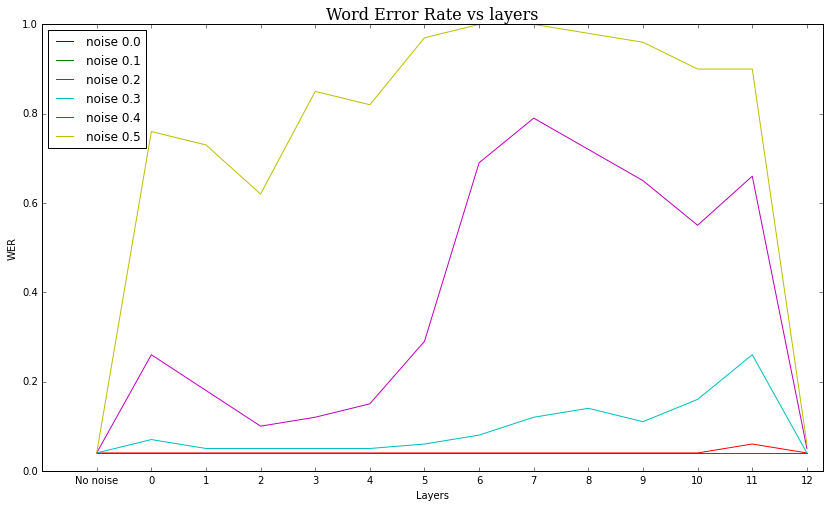

In [3]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

fig = plt.figure(figsize=(14, 8))

for i, cur in enumerate(vals[:-1]):
    plt.plot(layers, cur, alpha=1, label="noise {}".format(np.round(noises[i], 2)))
plt.legend(loc = 'upper left')
plt.xticks(layers + [12.3], ["No noise"] + [str(x) for x in layers[1:]] + [''])
plt.xlabel("Layers")
plt.ylabel("WER")
plt.title("Word Error Rate vs layers", fontsize=16, family='serif')
plt.savefig('wer_vs_layers.pdf')
plt.show()

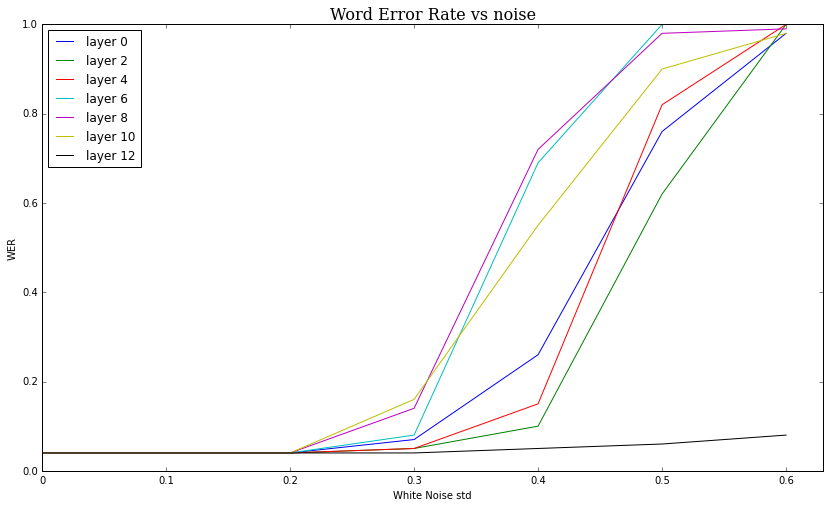

In [4]:
fig = plt.figure(figsize=(14, 8))

vals_T = np.array(vals).T

layer = -1
for i, cur in enumerate(vals_T):
    if i % 2 == 0:
        continue
    plt.plot(noises, cur, alpha=1, label="layer {}".format(layers[i]))
xtix = [0, .1, .2, .3, .4, .5, .6]
plt.xticks(xtix + [.63], [str(x) for x in xtix] + [''])
plt.legend(loc = 'upper left')
plt.xlabel("White Noise std")
plt.ylabel("WER")
plt.title("Word Error Rate vs noise", fontsize=16, family='serif')
plt.savefig('wer_vs_noise.pdf')
plt.show()